# Support Vector Machines to predict stable crystal compositions

In this notebook you will work with three datafiles: ex6data1.dat, ex6data2.dat and ex6data3.dat. They contain information about experiments of a three hypothetical materials: Simpilian, Complexian, Absurdian as function of their composition presented by coordinates (X1,X2). The material can either form a form a 'good' single homogeneous crystal (1) or have decomposed in a 'bad' poly-crystalline sample (-1). It is your task to find the boundary between these two phases based on a finite experimental dataset. The complexity of the decision boundary grows from example 1 to 3. The data is linearly separable in ex.1 and 2 by either a straight line or a curvy line, respectively. In example 3 you will encounter that the experimental data close to the decision boundary is diffuse or contains noise/errors.


## Part 1. The Genetic Algorithm

We are going to start by coding a general genetic algorithm that can be used to maximize an arbitrary fitness function. You will first test your code by maximizing 

$$f(\boldsymbol{\theta})=-(\theta_0-10)^2-(\theta_0-\theta_1)^2-(\theta_0-\theta_1-\theta_2-3)^2$$. 

Derive the solution analytically yourself. <em>Answer:</em> $\boldsymbol{\theta} =\{10,10,-3\}$. 

In [1]:
# importing the required modules
import numpy as np 
from math import ceil
import random
import matplotlib.pyplot as plt
import pdb
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

In [2]:
def f(theta):
    """
    computes the fitness of individual with genome theta according to the equation
    fitness = -(theta[0]-10)^2 - (theta[0]-theta[1])^2 - (theta[0]-theta[1]-theta[2]-3)^2 

    Parameters
    ----------
    theta : (3,) ndarray of float (the genome of the individual)
    
    Returns
    -------
    fitness : float
        The fitness of theta

    """
    
    '''YOUR CODE GOES HERE '''
    ##pdb.set_trace()
    ##print(theta.shape)
    fitness = -(theta[0]-10)**2 - (theta[0]-theta[1])**2 - (theta[0]-theta[1]-theta[2]-3)**2 
    
    return fitness

We define $K$ vectors $\boldsymbol{\theta}_k$, $k=0, \ldots, K-1$ that serve all as approximations of the real maximum. Every vector in this collection has a certain fitness $f_k = f(\boldsymbol{\theta}_k)$. We will apply a genetical algortithm in this notebook, in which each $\boldsymbol{\theta}_k$ is an **indiviual**.

For the time being assume these vectors are sorted according decreasing fitness. So $\boldsymbol{\theta}_0$ has the largest fitness $f_0$ and $\boldsymbol{\theta}_{K-1}$ the lowest fitness $f_{K-1}$. Genetically the vector $\boldsymbol{\theta}_0$ is stronger $\boldsymbol{\theta}_1$, etc.

After initializing a population with random **genomes** and sorting them according to fitness, we are going to generate a new population, again of size $K$. (You will see that there are quite some choices to be made in the sequal, but, strangely enough, it does not matter so much how you choose them: this genetic algorithm works 'all the time'.) 
We need two functions  `cross(theta1, theta2)` and   `mutate(theta)` in order to generate a new population.

- The function `cross(theta1, theta2)` combines individuals $theta1, theta2$, to a new genome/individual  
- The function `mutate(theta)` mutates individual $theta$


In [3]:
rng = np.random.default_rng()

def cross(theta1, theta2):
    """
    generates a new individual by crossing genes from individuals theta1 and theta2 
    by taking half the genes (randomly chosen) from theta1 and the others from theta2

    Parameters
    ----------
    theta1, theta2 : (N,) ndarray of float (N is the number of genes of the genomes)
        The two indivuals/genomes that will be crossed
    
    Returns
    -------
    crossed_theta : (N,) ndarray of float (N is the number of genes of the genomes)
        The new individual/genome

    """
    

##Option 4 (similar to option 1
    length = len(theta1)
    crossed_theta = []
    selection = random.sample(range(length), length // 2)
    #print(selection)
    
    # Create the new individual using the selected genes
    for i in range(length):
        if i in selection:
            crossed_theta.append(theta1[i])
        else:
            crossed_theta.append(theta2[i])

    return crossed_theta


def mutate(theta):
    """
    mutates an individual theta by adding a randomly chosen values to randomly chosen genes 

    Parameters
    ----------
    theta : (N,) ndarray of float (N is the number of genes of the individual)
        The individual/genome that gets mutated
    
    Returns
    -------
    mutated_theta : (N,) ndarray of float (N is the number of genes of the individual)
        The new individual/genome

    """
    length=len(theta)
    randomsize= np.random.randint(0,2)
    #print(randomsize)
    mutated_theta=[0,0,0]
    selection = random.sample(range(length), randomsize)
    
    for k in selection:
        theta[k] += np.random.randn()
        mutated_theta = theta    
        
    return mutated_theta

# mutate([1,2,3])

These functions allow us to combine genomes of individuals. We of course now need a strategy **which individuals** are going to take part in it. As a first attempt, lets test the following genetic algorithm:

As the individuals with a low index are strong, we let the strongest $25\%$ be part of the new population as well.

For the other $75\%$ we are going to combine the genomes of two parents, $A, B$, giving an individual (offspring) $C$ with  

| range | A: parent 1 | B: parent 2 | C: offspring |
|---|:---:|:---:|:-------------------------------------------------------------------------------:|
|$$\text{first }25\%$$ | none |  none | $$\boldsymbol{\theta}_k, \text{with }k=0..K/4-1$$ | 
|$$\text{second }25\%$$ | $$\boldsymbol{\theta}_k$$ | $$\boldsymbol{\theta}_{k+1}$$ | $$\text{cross(A,B) + mutate, } k=0..K/4-1$$ |
|$$\text{third } 25\%$$ | $$\boldsymbol{\theta}_k$$ | $$\boldsymbol{\theta}_r$$ | $$\text{cross(A,B) + mutate, } k=0..K/4-1, r \text{ is random}$$|  
|$$\text{fourth } 25\%$$ | $$\boldsymbol{\theta}_r$$ | $$\boldsymbol{\theta}_s$$ | $$\text{cross(A,B) + mutate, } r \text{ and } s \text{ taken random}$$ | 

For convenience we take $K$ to be a multiple of $4$, so it will be straightforward to split the population in the 4 groups. And again: change the rules and see if you can do better than my first attempt!

The resulting algorithm may seem to be slow. However, if the number of parameters becomes (much) larger the algorithm still works more or less at the same speed.

In [4]:
def cross_and_mutate(population):
    """
    generates a new population of individuals by crossing and mutating 

    Parameters
    ----------
    population : (K, N) ndarray of float (K is the number of individuals, N is the number of genes of the individual)
        The population used to generate the new population. The population is assumed to be in order of fitness
        - K number of individuals (amount of thetas)
        - N length of a theta (individual)
    
    Returns
    -------
    offspring : (K, N) ndarray of float (see above)
        The new population

    """
    offspring = []
## for the first 25% do nothing 
    for k in range(0, population.shape[0]-1): ## for all vectors in the population, k is index of the vector 
        if  population.shape[0]/4-1 < k < population.shape[0]/2:
            ##index is (part of second quarter)
            offspring_el = cross(population[k], population[k+1])
            ##print(k,':', offspring_el)
            offspring_el = mutate(offspring_el)
            ##print(k,':', offspring_el)
            offspring.append(offspring_el)
        if  population.shape[0]/2  <= k < population.shape[0]/4 *3 : ## index is part of third quartile
            ##random_index = random.randint(0, population.shape[0]-1)
            r = np.random.randint(population.shape[1]/2 -1 ,population.shape[1]/4 *3 -1) ##generate a random index in poulation to retrieve a random parent r
            offspring_el = cross(population[k], population[r])
            offspring_el = mutate(offspring_el)
            offspring.append(offspring_el)
        if population.shape[0]/4 *3  <= k <= population.shape[0]-1: ## last quartile
            s= 0
            
            ##random_index = random.randint(0, population.shape[0]-1)
            r = np.random.randint(population.shape[0]/4 *3 -1,population.shape[0]) ##generate a random index in poulation to retrieve a random parent r
            ##random_index = random.randint(0, population.shape[0]-1)
            s = np.random.randint(population.shape[0]/4 *3 -1,population.shape[0])  ##generate a random index in poulation to retrieve a random parent s
            
            offspring_el = cross(population[r], population[s])
            offspring_el = mutate(offspring_el)
            offspring.append(offspring_el)
        else:
            offspring.append(population[k])
            #print(offspring[0]),
#     print(offspring)
    return offspring



In [5]:


def run(f, K, N, num_generations = 1000):
    """
    executes the genetic algorithm to maximize a fitness function 

    Parameters
    ----------
    f: function:  returns a fitness value and has as argument an individual/genome (ndarray of shape (N,))
    K: integer : size of the population (multiple of 4)
    N: integer : number of genes in an individual
    num_generations: integer : number of generation that are executed
    
    Returns
    -------
    (theta, fitness_history): tuple
        theta: ndarray(N,) of float representing the individual.genome that yielded the best fitness
        fitness: ndarray(num_generations, ) of float the best fitness after each generation

    """
    
    # make sure K is always a multiple of 4, if not: raise an exception
    if K%4 != 0:
        raise ValueError('K should be a multiple of 4') 
    K = int(K)
    
    ## Generate population and find fitness
    population = np.random.uniform(-1, 1, size=(K, N)) ##generate random population of shape K,N
    #print(population.shape)
    fitness_now = np.zeros(K) ## fitness now is an array of dimension K for all thetas in the population
    fitness_history=[]
    
    for k in range(K):
        fitness_now[k]=f(population[k]) ##call function f for each theta_k part of population 
        ##print(fitness_now[k])
        #print(k)
    sorted_population = population[np.argsort(fitness_now)]
    
   ## print(fitness_now)

    
#     fitness_best = np.max(fitness_now) ##tracking the best fitness for the history
#     theta = population[np.argmax(fitness_now)]
#     fitness_history.append(fitness_best) ## record best fitness
    for i in range(num_generations+1):
        for k in range(K):
            fitness_now[k]=f(population[k])
        fitness_now= np.array(fitness_now)
        population= np.array(population)
        sorted_population = population[np.argsort(fitness_now)[::-1]]
        
        fitness_history.append(fitness_now[0])
        population = cross_and_mutate(sorted_population)

        
    
    return(population[0], fitness_history)

[10.00012787 10.00090117 -3.0008256 ]


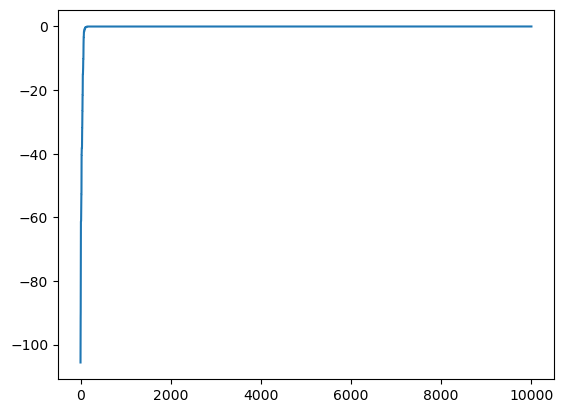

In [6]:
# execute the genetic algorithm

K = 24  # population size
N = 3  # number of genes in the genome
num_generations = 10000

theta, fitness = run(f, K, N, num_generations) 

print(theta)
plt.plot(fitness)  # plot the evolution of the fitness

This should converge to fitness = 0 best genome  $\boldsymbol{\theta} = [10, 10, -3]$

## Part 2. The Support Vector Machine


**We have now setup the algorithm an now apply it to data sets:**

- The first we do by using a package **sklearn**. 
- Second, we will solve it by using the genetic algorithm. 
- Later on you will use the package **sklearn** on more difficult data sets (to write a code that does what **sklearn** can do will take many ECs....


The data sets below will be data in 2D with two types: $y=1$ and $y=-1$ . 

### Example Dataset 1: Material Simpilian

In [7]:
# below two plot functions are defined that help visulaizing the results and the dataset.
# one for plotting the data and the decision boundary and margins of the SVM solution
# one for plotting the data and the results from the SVM from sklearn

def plotdata(X, y, theta=None):
    """
    plots the data and optionally the decision boundary and margins 

    Parameters
    ----------
    X: ndarray of size (M, 2) : data, with M the number of samples and 2 features
    y: ndarray of size (M,) :  labels of the datapoints (either 1 or other)
    theta: ndarray(3,) : solution of the SVM decision boundary theta[0] = bias, theta[1] and theta[2] are the weights
                        if None (default) no baoundary is plotted
    
    Returns
    -------
    None
    """
    mask = y == 1
    plt.scatter(*X[mask,:].T, s=50, c='k', marker='+', label='1')
    plt.scatter(*X[~mask,:].T, s=50, c='y', marker='o', label='-1')
    
    # optionally plot decision boundary 
    if theta is not None:
        x = np.linspace(min(X[:,0]), max(X[:,0]), 10)
        b, w1, w2 = theta
        y_db = -w1 / w2 * x - b / w2  # see eq 4.5 reader
        # margins
        y_margin1 = y_db + 1 / w2  # see eq. 4.9 reader with gamma=1
        y_margin2 = y_db - 1 / w2
        plt.plot(x, y_db, label='decision boundary')
        plt.plot(x, y_margin1, ':r', label='margins')
        plt.plot(x, y_margin2, ':r')
        
    plt.legend()
    plt.xlabel('x1')
    plt.ylabel('x2')

    
def plot_svc(svc, X, y):
    """
    plots the results from the sklearn SVM fit

    Parameters
    ----------
    svc: instance of sklearn.svm._classes.SVC
    X: ndarray of size (M, 2) : data, with M the number of samples and 2 features
    y: ndarray of size (M,) :  labels of the datapoints (either 1 or other)
    
    Returns
    -------
    None
    """
    # first plot the data and decisionboundary
    plotdata(X, y)
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=plt.gca(), alpha=0.4, cmap=plt.cm.Paired, response_method="predict")
 
    # plot the supportvectors
    plt.scatter(svc.support_vectors_[:,0], svc.support_vectors_[:,1], c='k', marker='|', s=100, linewidths=1)
    plt.title(f'C={svc.C}; Number of support vectors: {svc.support_.size}')    
   
    plt.xlabel('x1')
    plt.ylabel('x2')
    

First read the dataset and inspect the data and make a plot.

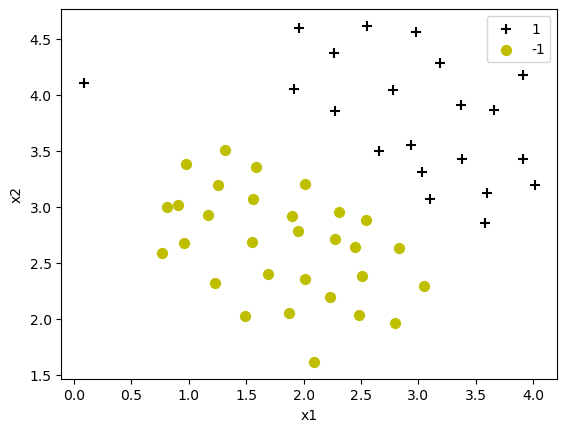

In [8]:
FILENAME = 'ex6data1.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)

# split the data in features and labels
X1 = data[:,:2]
y1 = data[:,2]

# make a plot of the data
plotdata(X1, y1) 

We first make the data set a little simpler: the point on the left changes identity ($1 \to -1$)

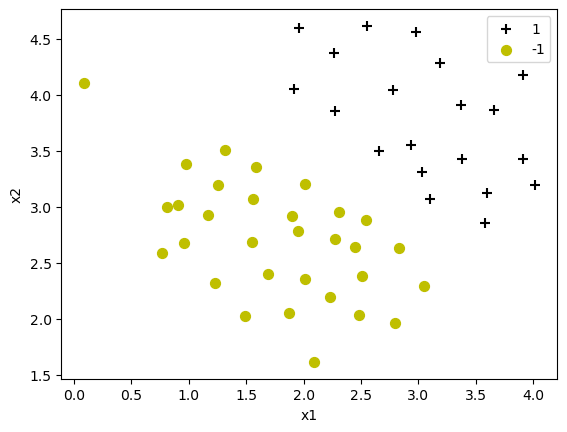

In [9]:
y1[50] = -1
plotdata(X1, y1)

This is what SVC from the package does. What is the function of the parameter C?

'"\nC is a control variable between maximizing the distance between decision boundary \nand closest data point (margin) and minimizing th classification error. The smaller the C the softer the \nmargins aka more misclassifications are allowed and there is a wider margin. As C increases, we emphasize correct classification\nEg. C = 1 -->10 misclassification\n    C = 10 --> 3 misclassification\n\n'

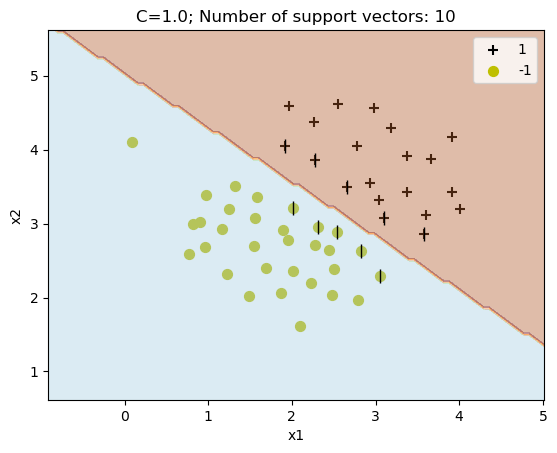

In [10]:
clf = SVC(C=1.0, kernel='linear')
clf.fit(X1, y1)
plot_svc(clf, X1, y1)

""""
C is a control variable between maximizing the distance between decision boundary 
and closest data point (margin) and minimizing th classification error. The smaller the C the softer the 
margins aka more misclassifications are allowed and there is a wider margin. As C increases, we emphasize correct classification
Eg. C = 1 -->10 misclassification
    C = 10 --> 3 misclassification

"""


**Implement the optimalisation as as defined below using the genetic algorith that we already have in the run() function. You can also find it in Eq. (4.12)of the lecture notes or (7.3) in Bishop.**

Find $\mathbf{w}$ and $b$ that maximize the margin, while correctly classify all data:<br>
  argmax$_{\mathbf{w},b} \left \{ \frac{1}{\| \mathbf{w} \|} \displaystyle \min_m \left \{ y^{(m)} \left ( \mathbf{w}^T \mathbf{x}^{(m)} + b \right) \right \} \right \},\;\; $
    $ \text{subject to }y^{(m)} \left ( \mathbf{w}^T \mathbf{x}^{(m)} + b \right) \geq 0$
    
What is the fitness when the hyperplane of your SVM does not properly classify all points? Add a penelaty term to the fitness function that adds a penealty of size C for each misclassification, or use the hinge loss function (this is the better choice).

C:\Users\onurd\AppData\Local\Temp\ipykernel_9052\3503892017.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  margin = 1 / np.linalg.norm(theta[1:])


solution: theta = [-4.45567781  1.21991941  0.31020529]


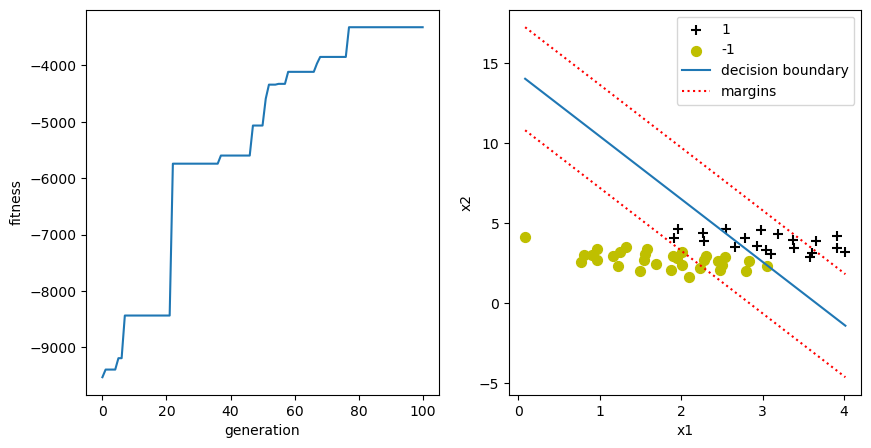

In [11]:
def fSVM(theta): 
    """
    computes the fitness of individual theta for a SVM classifier
    see for example the loss function as defined in eq 4.16 of the reader or (7.3) in Bishop
    Requires/assumes the presence of the global variables X and y that define the dataset 

    Parameters
    ----------
    theta : (3,) ndarray of float (the genes/parameters of the individual including the bias theta[0] and the two weights theta[1] and theta[2])
    
    Returns
    -------
    fitness : float
        The fitness of theta

    """
#     print(theta)
    maxb=np.zeros(1)
    maxw=np.random.uniform(-1, 1, size=(X.shape[0], 1)) 
    C=10000
    margin = 1 / np.linalg.norm(theta[1:])
    hinge_loss = 0.0
    summ=0
    minn= 100000000000000000000000
    for i in range(X.shape[0]):
        z = y[i] * (theta[1:]@ X[i] + theta[0])
        summ+=max( 0, 1-z)
        if(minn>z):
            minn=z
            maxw=theta[1:]
            maxb=theta[0]
    
#    fitness = 1/||w|| - C * sum(max(0, 1 - y(m)* (w.T.dot(x(m)) + b)))
    fitness = -1/2* np.linalg.norm(maxw)**2 - C/len(X) * summ

#     marginFinal = 1 / np.linalg.norm(maxw)
#     fitness= marginFinal- 0.1*summ

 
    return fitness

    
#     w= theta[1:] 
#     min_value = 100
#     for m in range(len(X)):
#         ##print(X[m], y[m])    
#         value_now = y[m]*(np.transpose(w)@X[m] + theta[0])
#         if value_now < min_value:
#             min_value = value_now
      
#     fitness = 1/np.linalg.norm(w)* min_value
#     return fitness

# define X and y as required by the fitness function
X = data[:,:2]
y = data[:,2]


# execute the genetic algorithm
K = 24  # population size
N = 3  # number of genes in the genome
num_generations = 100
theta, fitness = run(fSVM, K, N, num_generations)


# print/plot the results
print(f'solution: theta = {theta}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax1)
plt.plot(fitness)
plt.xlabel('generation')
plt.ylabel('fitness')

plt.sca(ax2)
plotdata(X1, y1, theta)

We will now switch back the classification of that single data point. How does this affect your hyperplane?

In [12]:
y1[50] = 1

C:\Users\onurd\AppData\Local\Temp\ipykernel_9052\3503892017.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  margin = 1 / np.linalg.norm(theta[1:])


solution: theta = [-3.56448416  0.9334667   0.42333229]


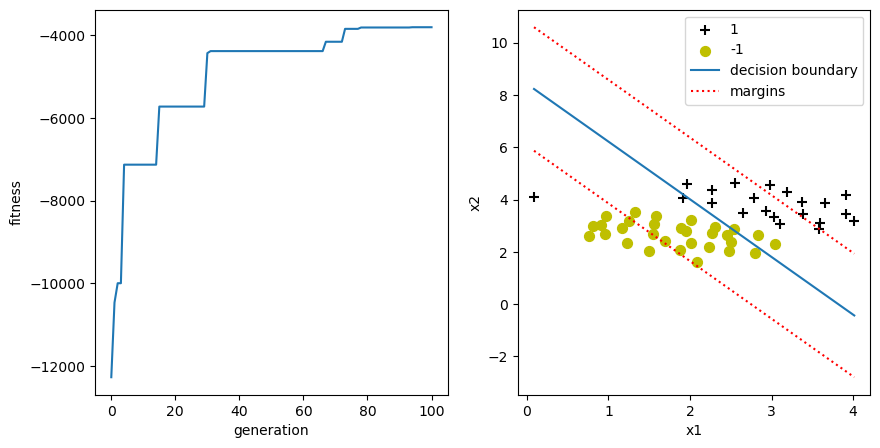

In [13]:
# define X and y as required by the fitness function
X = data[:,:2]
y = data[:,2]

# execute the genetic algorithm
K = 24  # population size
N = 3  # number of genes in the genome
num_generations = 100

theta, fitness = run(fSVM, K, N, num_generations)

# print/plot the results
print(f'solution: theta = {theta}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax1)
plt.plot(fitness)
plt.xlabel('generation')
plt.ylabel('fitness')

plt.sca(ax2)
plotdata(X1, y1, theta)

In [14]:
"""The hyperplane angle will change going to the left. This means ||w|| will increase, as weights of the support vectors increase. """

'The hyperplane angle will change going to the left. This means ||w|| will increase, as weights of the support vectors increase. '

Do the same but now with the sklearn functions. Compare different values of C

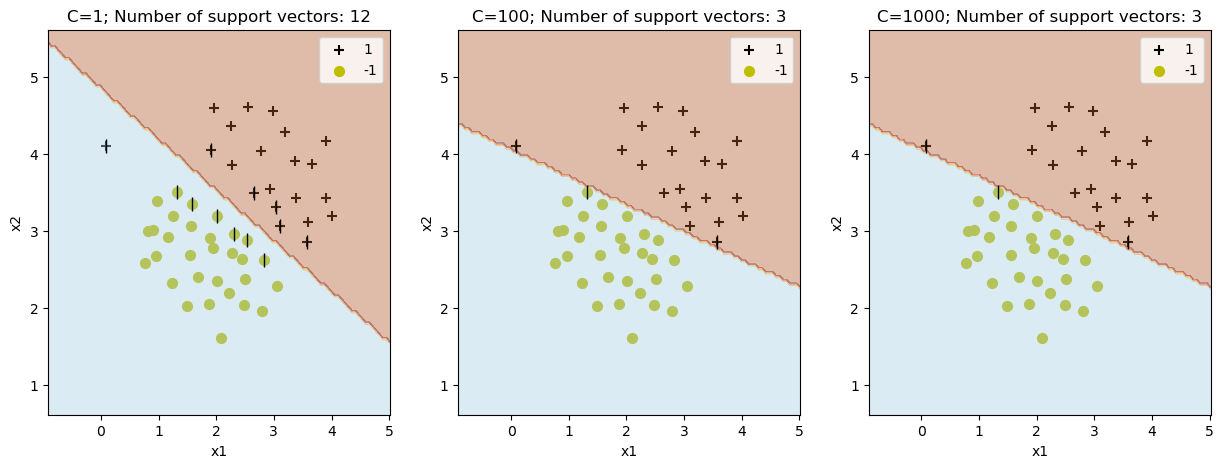

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

clf = SVC(C=1, kernel='linear')
clf.fit(X1, y1.ravel())
plt.sca(ax1)
plot_svc(clf, X1, y1)

clf = SVC(C=100, kernel='linear')
clf.fit(X1, y1.ravel())
plt.sca(ax2)
plot_svc(clf, X1, y1)

clf = SVC(C=1000, kernel='linear')
clf.fit(X1, y1.ravel())
plt.sca(ax3)
plot_svc(clf, X1, y1)


**Question.** Does the linear case work for C->0 and/or C->infinity work for the case that the dataset is not linearly separable? And what about the genetic code?
(set, e.g., the `X1[50,1] = 3` and `y1[50] = 1`)
How would you rephrase the genetic optimization such that you could use it for the non separable case as well?

In [16]:
"""
In the case of non linearly saparable datasets, the SVM classifier doesn't really work well as it attempt to seperate in classes 
through a hyperplane. Hence resulting in a non-optimal method of classification. This is why we look into polynomial (non-linear)
classfications, or acceptance of misclassifications. Using the kernel SVM through dual representation can help to seperate 
non-linearly seperable datasets.

Regarding the genetic algorithm, as it is a metaheuristic it can easily be modified to fit the non-linearly seperable case. Instead 
of the original fitness function which is an arbitrary one to seperate the classes, theta (the solution) can be checked for fitness 
also on how well it classifies the overall population, for example by using the distance between classes (hard/soft margins).

For example, fitness can be the reciprocal of the loss function, which leads to better solution means higher fitness values. 

THere are other emthods to deal with non-linearly separable classes, which also include mutation or crossing to preserve good classification 
across populations. 


SyntaxError: EOF while scanning triple-quoted string literal (1618842928.py, line 14)

### SVM with other Kernels

Below are two more data sets. Use the package sklearn for this. Dive into the manual of this package an figure out how you can get a good classifier. Explain how the methods works with other kernels. Change parameters, such as C, degree and other basis functions: what is their effect? 

#### Example Dataset 2: Material Complexian

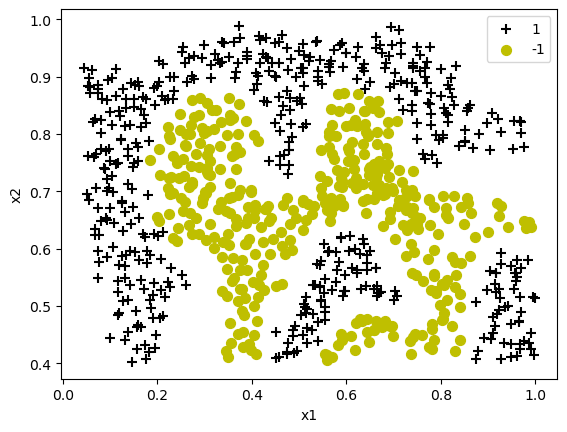

In [17]:
from sklearn import svm
FILENAME = 'ex6data2.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
X2 = data[:,:2]
y2 = data[:,2]

plotdata(X2, y2)

[1.]


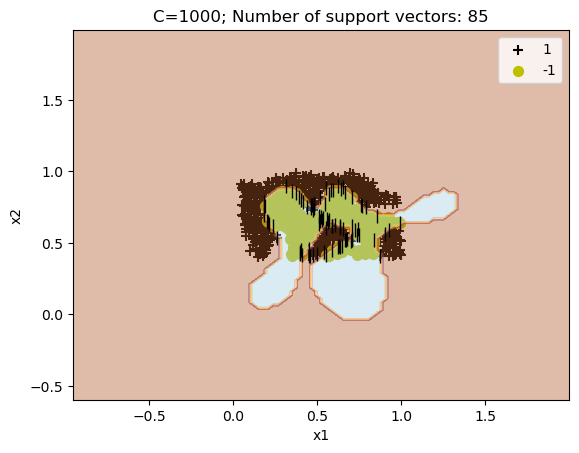

[1.]


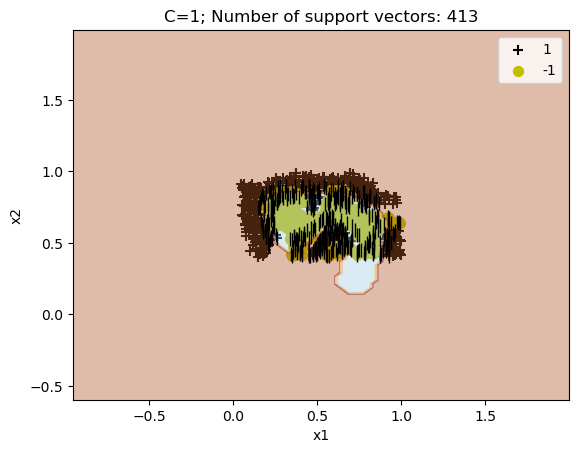

In [18]:
# write your code here

clf = svm.SVC(C=1000)
clf.fit(X2, y2)
plot_svc(clf, X2, y2)
print(clf.predict([[1,2]]))
plt.show()


clf = svm.SVC(C=1)
clf.fit(X2, y2)
plot_svc(clf, X2, y2)
print(clf.predict([[1,2]]))
plt.show()

#### Example Dataset 3: Material Absurdian

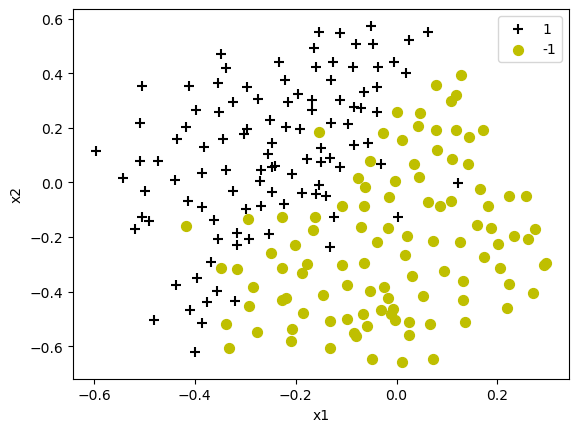

In [19]:
FILENAME = 'ex6data3.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
X3 = data[:,:2]
y3 = data[:,2]

plotdata(X3, y3)

[1.]


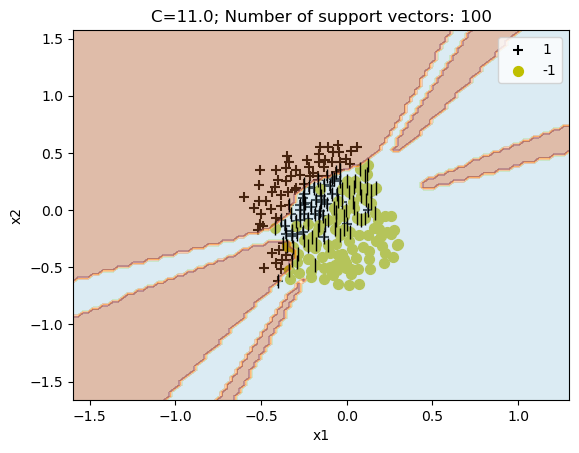

[-1.]


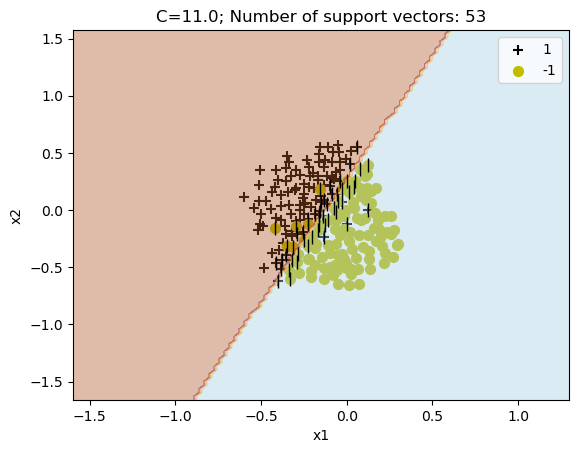

In [20]:
# write your code here
clf = SVC(C=11.0, kernel='poly',degree=11)
clf.fit(X3, y3)
print(clf.predict([[1,2]]))
plot_svc(clf, X3, y3)
plt.show()
clf = SVC(C=11.0, kernel='poly',degree=1)
clf.fit(X3, y3)
print(clf.predict([[1,2]]))
plot_svc(clf, X3, y3)
plt.show()


[1.]


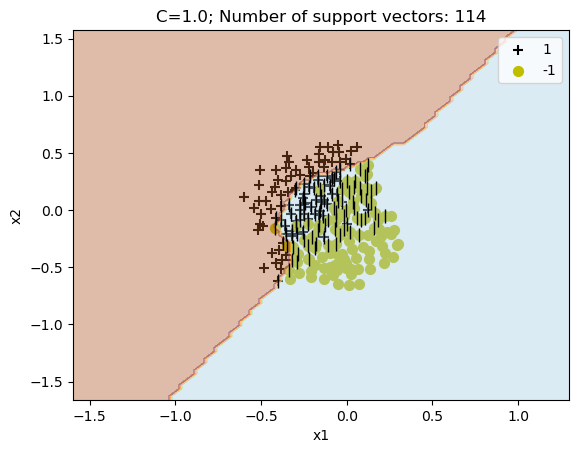

In [24]:
clf = SVC(C=1.0, kernel='poly',degree=11)
clf.fit(X3, y3)
print(clf.predict([[1,2]]))
plot_svc(clf, X3, y3)
plt.show()